# Delivery 3: Machine Learning and Deep Neural Networks with Tensorflow.

**Author: Dani Salgado Rojo**

In this notebook we include code for applying a Deep Neural Networks with Tensorflow to a classification problem.

We use the famous Iris dataset that contains data about three clases of iris plants and 4 features for each observation.

In a previous delivery (see https://github.com/dsalgador/mathematics-for-bigdata/tree/master/Deliveries/Delivery2) we used TDA (Topological Data Analysis) to analyse the Iris data set with persistence diagrams. These techinques didn't give us a "immediate" way to classify the data in three classes, they just allowed us to spearate in two groups (one with a single class and another containing the other two classes).

In this delivery we will see if a Deep Neural Network allows us to classify the data in all three classes and with an acceptable accuracy and performance. We reuse and adapt some lines of codes that has been already used for my Master's Thesis in Deep Reinforcement Learning (see Imitation Learning folder in https://github.com/dsalgador/master-thesis )

## Visualizing the dataset

To familiarize ourselves with the data, we consider the following code that returns some graphical visualizations:
* The first one plots the sepal width v.s. the sepal length for each observation, and there are used three colours to distinguish each class of iris plant.
* The second plot is a three dimensional plot of the dataset using the first three PCA directions (since we ahve four features, the plot for the whole dataset would be four dimensional).

In [1]:
# Source: http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


In [2]:
iris

{'DESCR': 'Iris Plants Database\n====================\n\nNotes\n-----\nData Set Characteristics:\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)\n    ============== ==== ==== ======= ===== ==

In [3]:
import numpy as np

n_classes = len(np.unique(iris.target))
n_features = len(iris.feature_names)
print("There are {} classes and observations with {} features".format(n_classes, n_features))

There are 3 classes and observations with 4 features


# Preparing data for training, validating and testing

In [4]:
import pandas as pd

#Observations
X = pd.DataFrame(iris.data)
#Targets
y= pd.DataFrame(iris.target)

In [5]:
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


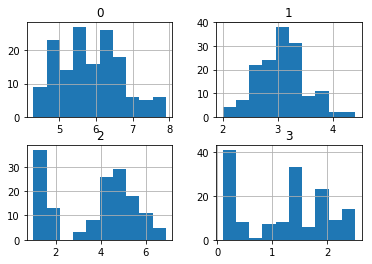

In [6]:
%matplotlib inline
X.hist();

In [7]:
n = len(X)
print(n)

150


## Split the dataset in train and test subdatasets

Since the whole dataset only contains 150 observations, we will only consider a train and test subdatasets (not a validation one) to perform classification analysis.

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [9]:
np.random.seed(42)
shuffle_index = np.random.permutation(n)
X = iris.data[shuffle_index]; y = iris.target[shuffle_index]

n_train = int(np.ceil(0.8 * n))
n_test = n - n_train

X_train = X[0:n_train].astype('float32'); y_train = y[0:n_train];
X_test = X[n_train:].astype('float32'); y_test = y[n_train:];

In [10]:
X_train[1:5]

array([[5.7, 3.8, 1.7, 0.3],
       [7.7, 2.6, 6.9, 2.3],
       [6. , 2.9, 4.5, 1.5],
       [6.8, 2.8, 4.8, 1.4]], dtype=float32)

# Deep Neural Network Classifier in Tensorflow

In [11]:
import tensorflow as tf
import os
import time 

from sklearn.preprocessing import StandardScaler
from datetime import datetime


/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
# Create a simulations' directory
sim_directory = './simulations'
if not os.path.exists(sim_directory):
    os.makedirs(sim_directory)

## Deep Neural Network model (architecture)

In [13]:
SIMULATION = 10

# Simulation parameters
simulation_directory = './simulations/simulation{}'.format(SIMULATION)
if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")
    
model_file = simulation_directory + '/final_nn_classifier_sim{}.ckpt'.format(SIMULATION)
graph_file =  '{}.meta'.format(model_file)  

# File to output performance metrics during training
training_file = simulation_directory+'/training-metrics.csv'.format(SIMULATION)

#test_file = simulation_directory+'/testing-states.csv'.format(SIMULATION)

In [14]:
reset_graph()

seed = 42
learning_rate = 0.001 #0.01

epochs = 3000 
batch_size = 10 #50

summary_freq = 10#np.ceil(epochs/10) #200
output_freq = 10*summary_freq #np.ceil(epochs/10) #200


hidden1_neurons = 20 #100
hidden2_neurons = 10 #50

scaling = True

regularization = True
beta = 0.01

if scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.astype(np.float64))
    #X_val = scaler.fit_transform(X_val.astype(np.float64))
    X_test = scaler.fit_transform(X_test.astype(np.float64))
    model_file = simulation_directory + '/final_nn_classifier_scaled_sim{}.ckpt'.format(SIMULATION)

tf.set_random_seed(seed)

with tf.name_scope("dnn"):
            # 1. Parameters to determine the NN architecture

            n_inputs = n_features
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.sigmoid
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.sigmoid
            n_outputs = n_classes

            initializer = tf.contrib.layers.variance_scaling_initializer(seed = seed)
            
            # Regularization of weights
#             if regularization:
#                 regularizer = tf.contrib.layers.l2_regularizer(scale = beta)
#             else:
            regularizer = None
            # 2. Build the Neural Network
            
            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            y = tf.placeholder(tf.int64, shape = (None), name = "y")
            
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = initializer,
                                     kernel_regularizer = regularizer,
                                     name = "hidden1")
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = regularizer,
                                     name ="hidden2")
            logits = tf.layers.dense(hidden2, n_outputs,kernel_initializer = initializer,
                                    kernel_regularizer = regularizer,
                                    name = "hidden3")
            
            if regularization:
                dim1 = [n_inputs, n_hidden1, n_hidden2]
                dim2 = [n_hidden1, n_hidden2 , n_outputs]

                all_weights = []

                for i in range(1,4):
                    with tf.variable_scope("hidden{}".format(i), reuse=tf.AUTO_REUSE):
                        weights = tf.get_variable('kernel', shape = [dim1[i-1], dim2[i-1]])
                        tf.summary.histogram('weights-hidden-{}'.format(i), weights)
                        all_weights.append(weights)

            
with tf.name_scope("loss"):
            if regularization:
                regularizer =  tf.nn.l2_loss(all_weights[0])
                for i in range(1,len(all_weights)):
                    regularizer = regularizer + tf.nn.l2_loss(all_weights[i])
            
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                                      logits = logits)
            if regularization:
                xentropy = xentropy + beta * regularizer
            
            loss = tf.reduce_mean(xentropy, name = "loss")
            
#             if regularization:
#                 reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
#                 loss = loss +  sum(reg_losses) # * beta
       
tf.summary.scalar('average_cross_entropy', loss)
            
with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            optimize = optimizer.minimize(loss)
            
with tf.name_scope("eval"):
            # Accuracy
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
tf.summary.scalar('accuracy', accuracy)

            
with tf.name_scope("action"):
            outputs = tf.nn.softmax(logits)
            # 3. Select a predicted class based on the estimated probabilities
            #predicted_class = tf.multinomial(tf.log(outputs), num_samples = 1)
            predicted_class = tf.argmax(outputs, axis = 1)
with tf.name_scope("confusion-matrix"):
            # Confusion matrix
            conf_mx = tf.confusion_matrix(labels=y, predictions=predicted_class)
            
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
        
if model_file != None:
            saver = tf.train.Saver()
        

def fetch_batch(X,y,epoch, batch_index, batch_size, data_size, n_batches):
        np.random.seed(epoch * n_batches + batch_index)  
        indices = np.random.randint(data_size, size=batch_size)  
        X_batch = X[indices] 
        y_batch = y[indices] 
        return X_batch, y_batch

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = sim_directory +"/tf_logs"
log_dir = "{}/run-{}-sim{}/".format(root_logdir, now, SIMULATION)

Instructions for updating:
Use the retry module or similar alternatives.


## Training

In [15]:
round_time = 2
    
best_acc_val = 0
acc_val = 0

# Output headers to file
with open(training_file,'w') as f:
     np.savetxt(f, [["epoch", "acc_train", "acc_test", "best_acc_test"]], fmt="%s", delimiter=',')    

with tf.Session() as sess:
        tf.set_random_seed(seed)

        time_start = time.time()
        
        train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
        val_writer = tf.summary.FileWriter(log_dir + '/test')
        
        init.run()
        N_TRAIN = X_train.shape[0]
        m = y_train.shape[0]
        
        n_batches = int(np.ceil(N_TRAIN/ batch_size))
             
        for epoch in range(epochs+1):
            print("\rEpoch: {}".format(epoch), end="")            
            for batch_index in range(n_batches):
                X_batch, y_batch = fetch_batch(X_train,y_train,epoch, batch_index, batch_size, m, n_batches)
                sess.run(optimize, feed_dict={
                                    y: y_batch,
                                    X: X_batch
                                })
            
            # Summaries, runtime outputs and data to files.
            if summary_freq != None: 
                            
                if epoch % summary_freq  == 0:
                    

                    summary, acc_train = sess.run([merged, accuracy], feed_dict={
                                        y: y_batch,
                                        X: X_batch
                                    })
                    train_writer.add_summary(summary, epoch)

                    summary, acc_val = sess.run([merged, accuracy], feed_dict={
                                        y: y_test,
                                        X: X_test
                                    }) 
                                    
                    val_writer.add_summary(summary, epoch)
                    
                    time_end = time.time()
                    if epoch % output_freq  == 0:
                        print(". Batch accuracy: ", round(acc_train, 4), 
                              " test. accuracy: ", round(acc_val,4),
                             " Best test. accuracy: ", round(best_acc_val, 4))#,
                             #" Elapsed time: ", round( (time_end-time_start)/60., round_time), " min.")
                    if best_acc_val < acc_val:                        
                        save_path = saver.save(sess, model_file)
                        #print(". Saved model with validation accuracy ", acc_val)
                        
                    best_acc_val = max(best_acc_val, acc_val)
                    
                    # Output data to files
                    with open(training_file,'ab') as f:
                         np.savetxt(f, [np.array([epoch, acc_train, acc_val, best_acc_val])], fmt='%.6f', delimiter=',')    
        
        train_writer.close()
        val_writer.close()
        time_end = time.time()
        print("\rElapsed time: ", round( (time_end-time_start)/60., round_time), " minutes.", " Best Test accuracy: ", best_acc_val)
        #save_path = saver.save(sess, model_file)   

Epoch: 0. Batch accuracy:  0.6  test. accuracy:  0.3333  Best test. accuracy:  0
Epoch: 100. Batch accuracy:  0.9  test. accuracy:  0.8333  Best test. accuracy:  0.9
Epoch: 200. Batch accuracy:  1.0  test. accuracy:  0.9  Best test. accuracy:  0.9
Epoch: 300. Batch accuracy:  1.0  test. accuracy:  0.9  Best test. accuracy:  0.9
Epoch: 400. Batch accuracy:  1.0  test. accuracy:  0.9  Best test. accuracy:  0.9333
Epoch: 500. Batch accuracy:  1.0  test. accuracy:  0.9  Best test. accuracy:  0.9333
Epoch: 600. Batch accuracy:  1.0  test. accuracy:  0.9333  Best test. accuracy:  0.9333
Epoch: 700. Batch accuracy:  1.0  test. accuracy:  0.9333  Best test. accuracy:  0.9333
Epoch: 800. Batch accuracy:  1.0  test. accuracy:  0.9  Best test. accuracy:  0.9333
Epoch: 900. Batch accuracy:  1.0  test. accuracy:  0.9333  Best test. accuracy:  0.9333
Epoch: 1000. Batch accuracy:  1.0  test. accuracy:  0.9  Best test. accuracy:  0.9333
Epoch: 1100. Batch accuracy:  1.0  test. accuracy:  0.9  Best tes

### Visualizing training performance

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


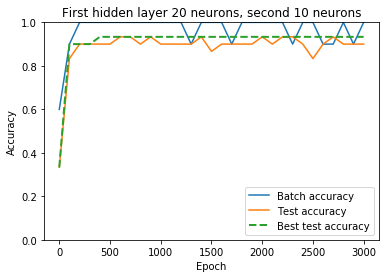

In [16]:
metrics = pd.read_table(training_file, sep = ",")
metrics.head()

def plot_accuracy(metrics):
    indices = [i for i in range(0,1000,10)]
    plt.plot(metrics['epoch'][indices],metrics['acc_train'][indices], label = "Batch accuracy")
    plt.plot(metrics['epoch'][indices],metrics['acc_test'][indices], label = "Test accuracy")
    plt.plot(metrics['epoch'][indices],metrics['best_acc_test'][indices], label = "Best test accuracy",linestyle = '--',linewidth = 2.0)

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.ylim(.0,1.0)
    
plot_accuracy(metrics) 
plt.title("First hidden layer {} neurons, second {} neurons".format(n_hidden1, n_hidden2))

plt.show()
plt.close()

We obtained a model that has at leat 0.9667 accuracy, which is very high if we take into account the fact 
that the test set is of 30 observations, and the 96.67% of 30 is 29, which means that only 1 test observation is predicted wrong.

If we use high batch sizes and no regularization, the network tends to overfitt the training data and then it generalizes very poorly for test data, leading to very low accuracies (abour 70 and 80 % instead of 96%).

Note also that the DNN that we have considered has just 30 neurons in the hidden layers, and it is enough to learn the iris dataset properly. We could even consider less neurons, and probably the results will be good enough.

### Visualizing training performance in Tensorboard


Tensorboard is a tool that allows us to visualize performance metrics such as accuracies, loss function values (cross entropy in our case), the distributions of weights and biases, etc.

To use it, you should be in the folder where this notebook is located (./Delivery3) and then type in a terminal:

*tensorboard --logdir tf_logs/*

and then open the URL that appears in the terminal in order to open Tensorboard

## Some validations

### Confusion matrices, train accuracy and test accuracy of the best model saved

In [17]:
with tf.Session() as sess: 
    saver.restore(sess, model_file)
    acc_test = sess.run(accuracy, feed_dict={
                                    y: y_test,
                                    X: X_test
                               })
    print("\nTest accuracy of the best model saved (according to validation accuracy): ", acc_test)
    
    conf_mx_test = sess.run(conf_mx, feed_dict={
                                    y: y_test,
                                    X: X_test})
    print('Confusion matrix for test data:\n', conf_mx_test
         )
    
    acc_train = sess.run(accuracy, feed_dict={
                                    y: y_train,
                                    X: X_train
                               })
    print("\nTrain accuracy of the best model saved (according to validation accuracy): ", acc_train)
                            
    conf_mx_train = sess.run(conf_mx, feed_dict={
                                    y: y_train,
                                    X: X_train})
    
    print('Confusion matrix for train data:\n', conf_mx_train
         )

INFO:tensorflow:Restoring parameters from ./simulations/simulation10/final_nn_classifier_scaled_sim10.ckpt

Test accuracy of the best model saved (according to validation accuracy):  0.93333334
Confusion matrix for test data:
 [[ 7  0  0]
 [ 0 11  0]
 [ 0  2 10]]

Train accuracy of the best model saved (according to validation accuracy):  0.96666664
Confusion matrix for train data:
 [[43  0  0]
 [ 0 35  4]
 [ 0  0 38]]
